# Pneumonia Classification - Neural Network Approach

The purpose of this approach is dual; firstly, to build a neural network that can accurately predict pneumonia from X-ray images, and, secondly, to explore the various image processing techniques that can lead to more robust models and, consequently, to more accurate results.

A simple Convolutional Neural Network was constructed, utilizing tensorflow and keras. *Transfer learning* was also implemented for the initialization of the first layers of the neural network, taking the weights from a neural network model trained on **Imagenet**. Use of weights from a pre-trained model can provide critical advantages for both the performance of a neural network and its accuracy; essentially the first models capture general details and fine-tuning is a much better approach than randomly initializing them.

The classes that we will work with for this approach are normal/pneumonia, and we will not delve into the sub-classes of the pneumonia class (viral/bacterial).

## Setup

### Libraries

The libraries that are utilized throughout this walkthrough are shown below:

In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import imgaug.augmenters as iaa

import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path

### Auxiliary Functions

The following auxiliary function **adjust_gamma** is utilized during the pre-processing of the input images, and performs gamma correction.

In [2]:
def adjust_gamma(image, gamma=1.0):
    #lookup table with the adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0)**invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

## Data

The data utilized for this project/walkthrough was saved to Google Drive due to storage space issues. However, it is readily available as a Kaggle dataset, [here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), which is where it was originally downloaded from.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define path to the data directory
data_dir = Path(
    '/content/drive/MyDrive/Colab Notebooks/PneumoniaClassification/chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

### Training Data

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_df = []

# Normal cases, setting label = 0
for img in normal_cases:
    train_df.append((img,0))

# Pneumonia cases, setting label = 1
for img in pneumonia_cases:
    train_df.append((img, 1))


train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None) # data frame
train_df = train_df.sample(frac=1.).reset_index(drop=True) # shuffling
train_df.head() # inspection

,image,label
0,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
1,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1
2,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
3,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1
4,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0


In [6]:
train_df['label'].value_counts()

1    3875
0    1341
Name: label, dtype: int64

Below we further inspect the training data, to check whether the two classes (normal/pneumonia) are balanced.

1    3875
0    1341
Name: label, dtype: int64


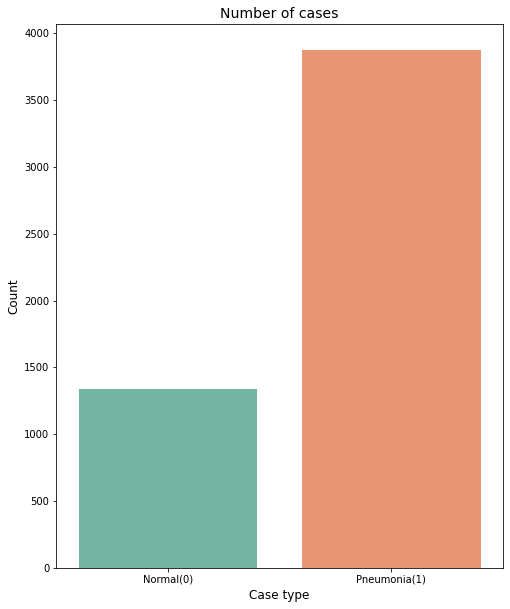


 Ratio Pneumonia:Normal = 2.889634601043997


In [7]:
# Visual Inspection
# Get the counts for each class
cases_count = train_df['label'].value_counts()
print(cases_count)
normal_counts = cases_count[0]
pneumonia_counts = cases_count[1]

# Plot the results 
plt.figure(figsize=(8,10))
sns.set_palette("Set2", 10)
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

print("\n Ratio Pneumonia:Normal = " + str(pneumonia_counts/normal_counts))

As shown in the barchart above, the two classes are **not balanced**. This is definitely an issue for the model, particularly during the Training step. 

To this end, we are going to apply data augmentation, and try to generate extra instances of images that belong to the normal class starting from images already present in our dataset. As shown above the ratio of normal to pneumonia images is approximately 3, meaning that for every image that belongs to the normal class we have 3 images that belong to the pneumonia class, in the training set.

For this reason, we are going to **generate 2 additional images per already existing normal cases by applying a random data augmentation technique**, taken from a set of potential techniques. The new normal case images are saved along with the existing ones in a new folder, creating a new "augmented"/"extended" set of training images.

The process described above only takes place to only augment the training set. For the validation and test sets we will be working with the existing ones for two main reasons: firstly, it is more important to *train* the model with a balanced set that validate or test it, and, secondly, in the majority of real-life scenarios the test or validation sets will not be balanced. With this mindset, we will continue with augmenting and splitting our dataset.

#### Data Augmentation

From the possible augmentation techniques we choose the following:

* Horizontal flip
* Rotation: either at a 20° angle or at a -15° one.
* Brightness increase: multiplying the pixel value by either 1.1 or 1.5
* Sharpening

An auxiliary function **enrich_normal** to perform data augmentation is also defined here. Its arguments are:

* *normal_train_df*: the dataframe containing the paths to the normal dataset instances.
* *outdir*: the output directory to write the newly generated instances of normal cases
* *extra*: the number of additional images to generate for each input normal image. In our case, since the ratio Pneumonia:Normal is close to 3, we need additional 2 images per normal image to be generated so that we achieve a more balanced training set.

Running **enrich_normal** will first resize the input image to (224,224) and then perform the augmentation, by choosing one of the techniques above, at random.

In [24]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # rotation
    iaa.Affine(rotate=-15), # rotation
    iaa.Multiply((1.1, 1.5)), #random brightness
    iaa.Sharpen(alpha=0.5)]) # sharpening

# Auxiliary function for data generation
def enrich_normal(normal_train_df, outdir, extra):
    os.chdir(outdir)

    # Get total number of samples in the data
    n = len(normal_train_df)
    
    count = 1
    for i in range(n):
        img_name = normal_train_df.iloc[i]['image']
      
        # read the image and resize
        img = cv2.imread(str(img_name))
        img = cv2.resize(img, (224,224))
        orig_img = img.copy()
        name = "NORMAL_EXTENDED_" + str(count) + ".jpeg"
        cv2.imwrite(name, orig_img)
        count +=1

        # Generating additional normal cases
        for j in range(extra):
            
            aug_img = seq.augment_image(img)
            name = "NORMAL_EXTENDED_" + str(count) + ".jpeg"
            cv2.imwrite(name, aug_img)
            count +=1

The code below generates and saves the additional normal instances. Running this is quite a consuming step, thus the code has been commened out as the training set has already been extended and the final training set has already been created

In [ ]:
# # Sub-setting the normal cases
# normal_train_df = train_df[train_df['label'] == 0] 
# outdir = train_dir / 'NORMAL_EXTENDED'
# # os.mkdir(outdir) # run once

# # Generate Extended normal images
# enrich_normal(normal_train_df, outdir, 2)

In [8]:
# New Training data

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL_EXTENDED'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

new_train_df = []

# Normal cases, setting label = 0
for img in normal_cases:
    new_train_df.append((img,0))

# Pneumonia cases, setting label = 1
for img in pneumonia_cases:
    new_train_df.append((img, 1))

new_train_df = pd.DataFrame(new_train_df, columns=['image', 'label'],index=None) # dataframe
new_train_df = new_train_df.sample(frac=1.).reset_index(drop=True) # shuffling
new_train_df.head() # inspection

,image,label
0,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
1,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
2,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
3,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
4,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1


0    4023
1    3875
Name: label, dtype: int64


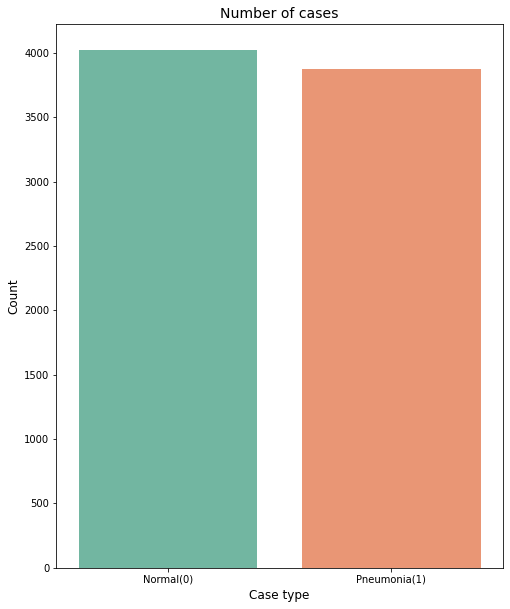

In [9]:
# Visual Inspection
# Get the counts for each class
cases_count = new_train_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(8,10))
sns.set_palette("Set2", 10)
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

As shown above, a more balanced training set is now available.

### Validation Data

In [10]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_df = []

# Normal cases, setting label = 0
for img in normal_cases:
    valid_df.append((img,0))

# Pneumonia cases, setting label = 1
for img in pneumonia_cases:
    valid_df.append((img, 1))

valid_df = pd.DataFrame(valid_df, columns=['image', 'label'],index=None) # dataframe
valid_df = valid_df.sample(frac=1.).reset_index(drop=True) # shuffling
valid_df.head() # inspection

,image,label
0,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1
1,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1
2,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
3,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
4,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0


### Test Data

In [11]:
# Get the path to the sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_df = []

# Normal cases, setting label = 0
for img in normal_cases:
    test_df.append((img,0))

# Pneumonia cases, setting label = 1
for img in pneumonia_cases:
    test_df.append((img, 1))

test_df = pd.DataFrame(test_df, columns=['image', 'label'],index=None) # dataframe
test_df = test_df.sample(frac=1.).reset_index(drop=True) # shuffling
test_df.head() # inspection

,image,label
0,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
1,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
2,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0
3,/content/drive/MyDrive/Colab Notebooks/Pneumon...,1
4,/content/drive/MyDrive/Colab Notebooks/Pneumon...,0


## Data Pre-processing

It is essential that we pre-process the input images -belonging either to the training, validation, or test set- so that they have the appropriate "properties" before supplying them to the neural network. We introduce a "base pre-processing" approach that includes all the necessary steps prior to supplying an image as input to the model, as well as some additional pre-processing techniques that we believe will enhance the images and provide a better accuracy for the model.

### Base Pre-Processing

With base pre-processing, the following steps are performed:

1. Image resizing: The model accepts a (112,112) image as input and, therefore, all images are resized to (112,112).
2. Channel Correction: Some images, even if they appear to be in grayscale, are in fact RGB images. We create the RGB versions of the images for all of the input images by stacking the color channel thrice, if the image is in grayscale.
3. Grayscale: Now that all images are in RGB, we can transform them all into grayscale so that we can supply them into the model.
4. Normalization: The pixel values are normalized by dividing their values with 255.

These steps are all essential in order to provide appropriate input for the neural network.

In [12]:
def base_pre(data):
    new_data = []
    new_labels = []

    normal_images = data.loc[data['label'] == 0,'image']
    pneumonia_images = data.loc[data['label'] == 1,'image']

    for img_name in normal_images:
        img = cv2.imread(str(img_name))
        # Resizing
        img = cv2.resize(img, (112,112))
        # Channel correction
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Normalization
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=2)
        new_data.append(img)
        new_labels.append(label)


    for img_name in pneumonia_images:
        img = cv2.imread(str(img_name))
        # Resizing
        img = cv2.resize(img, (112,112))
        # Channel correction
        if img.shape[2] == 1:
          img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Normalization
        img = img.astype(np.float32)/255.
        label = to_categorical(1, num_classes=2)
        new_data.append(img)
        new_labels.append(label)

    # Convert the list into numpy arrays
    new_data = np.array(new_data)
    new_labels = np.array(new_labels)

    return new_data, new_labels

We pre-process the data utilizing the function above.

In [ ]:
train_data, train_labels = base_pre(new_train_df)
valid_data, valid_labels = base_pre(valid_df)
test_data, test_labels = base_pre(test_df)

Apart from the essential pre-processign steps, we are also looking into further pre-processing steps that may (or may not) enhance the image quality and provide more accurate results when running the neural network. 

*Spoiler: Additional image pre-processing actually plays a major role in the improvement of the model's accuracy!* 

### Simple Pre-processing

Apart from image resizing, channel correction, grayscale transformation, and normalization we also create an alternative preprocessing approach, by introducing additional image pre-processing steps:

* Negative filter
* Addition

The above (simple) image pre-processing techniques are coupled with the base pre-processing ones and included in the following auxiliary function:

In [ ]:
def pre_simple(data):
    new_data = []
    new_labels = []

    normal_images = data.loc[data['label'] == 0,'image']
    pneumonia_images = data.loc[data['label'] == 1,'image']

    for img in normal_images:
        img = cv2.imread(str(img))

        # Resizing
        img = cv2.resize(img, (112,112))
        # Channel correction
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # == Extra Preprocessing == #
        img = (255-img)
        img = cv2.add(img, -30)
        # == #

        # Normalization
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=2)
        new_data.append(img)
        new_labels.append(label)


    for img in pneumonia_images:
        img = cv2.imread(str(img))

        # Resizing
        img = cv2.resize(img, (112,112))
        # Channel correction
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # == Extra Preprocessing == #
        img = (255-img)
        img = cv2.add(img, -30)
        # == #

        # Normalization
        img = img.astype(np.float32)/255.
        label = to_categorical(1, num_classes=2)
        new_data.append(img)
        new_labels.append(label)

    # Convert the list into numpy arrays
    new_data = np.array(new_data)
    new_labels = np.array(new_labels)

    return new_data, new_labels

We pre-process the data utilizing the function above.

In [ ]:
train_data_2, train_labels_2 = pre_simple(new_train_df)
valid_data_2, valid_labels_2 = pre_simple(valid_df)
test_data_2, test_labels_2 = pre_simple(test_df)

### Histogram Normalization

We further introduce histogram normalization to the pre-processing steps, and define the appropriate auxiliary function:

In [ ]:
def pre_histo(data):
    new_data = []
    new_labels = []

    normal_images = data.loc[data['label'] == 0, 'image']
    pneumonia_images = data.loc[data['label'] == 1, 'image']

    for img in normal_images:
        img = cv2.imread(str(img))

        # == Extra Preprocessing == #
        hist, bins = np.histogram(img.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        cdf_m = np.ma.masked_equal(cdf, 0)
        cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
        cdf2 = np.ma.filled(cdf_m, 0).astype('uint8')

        img = cdf2[img]
        img = (255 - img)
        img = cv2.add(img, -70)
        # == #

        # Resizing
        img = cv2.resize(img, (112, 112))
        # Channel correction
        if img.shape[2] == 1:
            img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Normalization
        img = img.astype(np.float32) / 255.
        label = to_categorical(0, num_classes=2)
        new_data.append(img)
        new_labels.append(label)

    for img in pneumonia_images:
        img = cv2.imread(str(img))
        # Resizing
        img = cv2.resize(img, (112, 112))
        # Channel correction
        if img.shape[2] == 1:
            img = np.dstack([img, img, img])
        # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # == Extra Preprocessing == #
        hist, bins = np.histogram(img.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        cdf_m = np.ma.masked_equal(cdf, 0)
        cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
        cdf2 = np.ma.filled(cdf_m, 0).astype('uint8')

        img = cdf2[img]
        img = (255 - img)
        img = cv2.add(img, -70)
        # == #

        # Normalization
        img = img.astype(np.float32) / 255.
        label = to_categorical(1, num_classes=2)
        new_data.append(img)
        new_labels.append(label)

    # Convert the list into numpy arrays
    new_data = np.array(new_data)
    new_labels = np.array(new_labels)

    return new_data, new_labels

We pre-process the data utilizing the function above.

In [ ]:
train_data_4, train_labels_4 = pre_histo(new_train_df)
valid_data_4, valid_labels_4 = pre_histo(valid_df)
test_data_4, test_labels_4 = pre_histo(test_df)

We should also note that we tested two different *Edge Detection* filters, the Sobel and Canny filters in order to see whether the processed images would "help" the model provide more accurate results. Unfortunately, running the model led to an accuracy of 50% during the validation step, which practically means the model assigned labels at random, and the *Edge Detection* approach as a pre-processing step for modifying the NN input was discarded.

Below we inspect some example images from the 3 pre-processed sets we created.

In [ ]:
plt.figure(figsize=(10, 10))

image = train_data[0]
plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.axis(False)
image = train_data_2[0]
plt.subplot(1, 3, 2), plt.imshow(image, cmap='gray'), plt.axis(False)
image = train_data_4[0]
plt.subplot(1, 3, 3), plt.imshow(image, cmap='gray'), plt.axis(False)

## Neural Network Model: Construction & Testing

For the purposes of classifying the normal/pneumonia cases a very simple neural model is constructed. Its input size is (112,112,1) and, therefore, all images have already been pre-processed to this size. Its structure is very simple, including 4 convolutional layers divided in 2 pairs, with MaxPooling and Dropout layers between each pair. Transfer learning was also utilized in the frame of this project by introducing weights to the first two layers from a model pre-trained on imagenet.

Below we define an auxiliary function that builds the model:

In [ ]:
def build_model():

    inp = Input(shape=(112, 112, 1), name='ImageInput')

    hid = Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_uniform',
                 input_shape=(112, 112, 1),
                 name='Conv1_1')(inp)
    hid = Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_uniform',
                 name='Conv1_2')(inp)
    hid = MaxPooling2D((2, 2), name='MaxPool1')(hid)
    hid = Dropout(0.2)(hid)

    hid = Conv2D(64, (3, 3),
                 activation="relu",
                 padding='same',
                 kernel_initializer='he_uniform',
                 name='Conv2_1')(hid)
    hid = Conv2D(64, (3, 3),
                 activation="relu",
                 padding='same',
                 kernel_initializer='he_uniform',
                 name='Conv2_2')(hid)
    hid = MaxPooling2D((2, 2), name='MaxPool2')(hid)
    hid = Dropout(0.2)(hid)

    hid = Flatten()(hid)
    hid = Dense(64, activation='relu', kernel_initializer='he_uniform')(hid)
    hid = Dropout(0.2)(hid)

    out = Dense(2, activation='softmax')(hid)

    model = Model(inputs=inp, outputs=out)

    return model

### Base Model

The *Base Model* is trained on the set that has been pre-processed with the basic pre-processing steps.

In [ ]:
base_model =  build_model()
base_model.summary()

#### Model Training: Importing weights from pre-trained model:

In [ ]:
# Open the VGG16 weight file
f = h5py.File(
    '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'r')

# Select the layers for which we want to set weight

w, b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1'][
    'block1_conv1_b_1:0']
base_model.layers[1].set_weights = [w, b]

w, b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2'][
    'block1_conv2_b_1:0']
base_model.layers[2].set_weights = [w, b]

f.close()
base_model.summary()

#### Model Training: Training Set

The model is trained on the training dataset with a batch size of 64 and for 10 epochs. Early Stopping and Checkpoint are also set, so that the best model is saved.

The code below can be skipped since it is a time-consuming one (that is why it has been commented out), and the model can be loaded directly from the saved file.

In [ ]:
# batch_size = 64
# nb_epochs = 10

# # Compile model
# es = EarlyStopping(patience=5)
# chkpt = ModelCheckpoint(
#     filepath=
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/best_initial_model',
#     save_best_only=True,
#     save_weights_only=True)

# base_model.compile(loss='binary_crossentropy',
#                    optimizer=Adam(learning_rate=0.0001, decay=1e-5),
#                    metrics=["accuracy"])

# # Fit the model
# base_model.fit(train_data,
#                train_labels,
#                batch_size=batch_size,
#                epochs=nb_epochs,
#                callbacks=[es, chkpt],
#                validation_data=(valid_data, valid_labels))

# base_model.save(
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/base_model.h5')

#### Inspection of Results

In [ ]:
# Load model
base_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ImageProcessing/base_model.h5')

# Get overall accuracy
test_loss, test_accuracy = base_model.evaluate(test_data,
                                               test_labels,
                                               verbose=0)
print('Total Accuracy on Test set=' + '> %.3f' % (test_accuracy * 100.0) + '%')

# Get predictions
preds = base_model.predict(test_data, batch_size=64)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

# Confusion matrix
cm = confusion_matrix(orig_test_labels, preds)

plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

### Model with Simple Pre-processing

A second model is trained, validated, and tested on data that have been pre-processed with the simple pre-processing steps.

#### Model Training: Importing weights from pre-trained model

In [ ]:
second_model = build_model()

# Open the VGG16 weight file
f = h5py.File(
    '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'r')

# Select the layers for which we want to set weight

w, b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1'][
    'block1_conv1_b_1:0']
second_model.layers[1].set_weights = [w, b]

w, b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2'][
    'block1_conv2_b_1:0']
second_model.layers[2].set_weights = [w, b]

f.close()
second_model.summary()

#### Model Training: Training Set

In [ ]:
# batch_size = 64
# nb_epochs = 10

# # Compile model
# es = EarlyStopping(patience=5)
# chkpt = ModelCheckpoint(
#     filepath=
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/best_second_model',
#     save_best_only=True,
#     save_weights_only=True)

# second_model.compile(loss='binary_crossentropy',
#                      optimizer=Adam(learning_rate=0.0001, decay=1e-5),
#                      metrics=["accuracy"])

# # Fit the model
# second_model.fit(train_data_2,
#                  train_labels_2,
#                  batch_size=batch_size,
#                  epochs=nb_epochs,
#                  callbacks=[es, chkpt],
#                  validation_data=(valid_data_2, valid_labels_2))

# second_model.save(
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/second_model.h5')

#### Inspection of Results

In [ ]:
# Load model
second_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ImageProcessing/second_model.h5')

# Get overall accuracy
test_loss, test_accuracy = base_model.evaluate(test_data_2,
                                               test_labels_2,
                                               verbose=0)
print('Total Accuracy on Test set=' + '> %.3f' % (test_accuracy * 100.0) + '%')

# Get predictions
preds = base_model.predict(test_data_2, batch_size=64)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels_2, axis=-1)

# Confusion matrix
cm = confusion_matrix(orig_test_labels, preds)

plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

### Model with Histogram Normalization Pre-processing

Another model is trained, validated, and tested on data that have been pre-processed with the simple pre-processing steps coupled with histogram normalization.

#### Model Training: Importing weights from pre-trained model

In [ ]:
fourth_model = build_model()

# Open the VGG16 weight file
f = h5py.File(
    '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'r')

# Select the layers for which we want to set weight

w, b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1'][
    'block1_conv1_b_1:0']
fourth_model.layers[1].set_weights = [w, b]

w, b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2'][
    'block1_conv2_b_1:0']
fourth_model.layers[2].set_weights = [w, b]

f.close()
fourth_model.summary()

### Model Training: Training Set

In [ ]:
# batch_size = 64
# nb_epochs = 10

# # Compile model
# es = EarlyStopping(patience=5)
# chkpt = ModelCheckpoint(
#     filepath=
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/best_fourth_model',
#     save_best_only=True,
#     save_weights_only=True)

# fourth_model.compile(loss='binary_crossentropy',
#                      optimizer=Adam(learning_rate=0.0001, decay=1e-5),
#                      metrics=["accuracy"])

# # Fit the model
# fourth_model.fit(train_data_4,
#                  train_labels_4,
#                  batch_size=batch_size,
#                  epochs=nb_epochs,
#                  callbacks=[es, chkpt],
#                  validation_data=(valid_data_4, valid_labels_4))

# fourth_model.save(
#     '/content/drive/MyDrive/Colab Notebooks/ImageProcessing/fourth_model.h5')

#### Inspection of Results

In [ ]:
# Load model
fourth_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ImageProcessing/fourth_model.h5')

# Get predictions
preds = fourth_model.predict(test_data_4, batch_size=64)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels_4, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()